<img style="max-width:20em; height:auto;" src="../graphics/A-Little-Book-on-Adversarial-AI-Cover.png"/>

Author: Nik Alleyne   
Author Blog: https://www.securitynik.com   
Author GitHub: github.com/securitynik   

Author Other Books: [   

            "https://www.amazon.ca/Learning-Practicing-Leveraging-Practical-Detection/dp/1731254458/",   
            
            "https://www.amazon.ca/Learning-Practicing-Mastering-Network-Forensics/dp/1775383024/"   
        ]   


This notebook ***(bodmas_malware_classifier.ipynb)*** is part of the series of notebooks From ***A Little Book on Adversarial AI***  A free ebook released by Nik Alleyne

### Malware Binary Classification with the BODMAS dataset  

#### BODMAS Dataset   
- https://liminyang.web.illinois.edu/data/DLS21_BODMAS.pdf   
- https://whyisyoung.github.io/BODMAS/
- https://drive.google.com/drive/folders/1Uf-LebLWyi9eCv97iBal7kL1NgiGEsv_    


@inproceedings{bodmas,  
  title = {BODMAS: An Open Dataset for Learning based Temporal Analysis of PE Malware},
  author = {Yang, Limin and Ciptadi, Arridhana and Laziuk, Ihar and Ahmadzadeh, Ali and Wang, Gang},
  booktitle = {4th Deep Learning and Security Workshop},
  year = {2021}
}

### Source of malware dataset   
- https://0xh3xa.github.io/awesome-malware-benign-datasets/    


### Lab Objectives:  
- Build a neural network to perform malware classification using the BODMAS dataset  
- Perform binary classification   
- Recognize that there are datasets out there for us to use, rather than having to start with our own   
- 


### Step 1:  
- Get our data  

In [1]:
# Import our needed libraries 

import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Get a quick summary of the model
import torchinfo

# Track the model experiments
import mlflow

from tqdm import tqdm

In [2]:
### Version of key libraries used  
print(f'Torch version used:  {torch.__version__}')
print(f'Numpy version used:  {np.__version__}')
print(f'Torchinfo version used:  {torchinfo.__version__}')
print(f'MLFlow version used:  {mlflow.__version__}')

Torch version used:  2.7.1+cu128
Numpy version used:  2.1.3
Torchinfo version used:  1.8.0
MLFlow version used:  3.1.1


In [3]:
# Setup the device to work with
# This should ensure if there are accelerators in place, such as Apple backend or CUDA, 
# we should be able to take advantage of it.

if torch.cuda.is_available():
    print('Setting the device to cuda')
    device = 'cuda'
elif torch.backends.mps.is_available():
    print('Setting the device to Apple mps')
    device = 'mps'
else:
    print('Setting the device to CPU')
    device = torch.device('cpu')

Setting the device to cuda


In [4]:
# Setup the text description class labels
class_labels = ['Benign', 'Malware']
class_labels

['Benign', 'Malware']

In [5]:
# Get the file containing the malware features and labels
bodmas_file_path = r'../data/bodmas.npz'
data = np.load(file=bodmas_file_path, allow_pickle=False)

# Extract only the features of the malware
malware_features = data['X'] 

# Get the labels 
malware_labels = data['y']

# Get the shape of the dataset
malware_features.shape, malware_labels.shape

((134435, 2381), (134435,))

With a shape of 2381 columns, from a linear layer perspective, we should have no concerns if building a neural network. Then again, Gradient Boosting has also been used to solve this problem with malware classification: https://whyisyoung.github.io/BODMAS/.   

We will use a neural network instead.  

In [6]:
# Get some statistics on the raw dataset
# Below results show that this dataset should be scaled
# For scaling we will use Standardization

print(f'Max value: {malware_features.max().item()}')
print(f'Min value: {malware_features.min().item()}')
print(f'Mean value: {malware_features.mean()}')
print(f'Std value: {malware_features.std()}')

Max value: 4294967296.0
Min value: -654044672.0
Mean value: 573773.4375
Std value: 29769684.0


In [7]:
# Peek into a sample
malware_features[0]


array([0.05674198, 0.00801749, 0.00776239, ..., 0.        , 0.        ,
       0.        ], dtype=float32)

In [8]:
# We see some 0s above. How many of these points are zero in this one sample
np.where(malware_features[0] == 0)[0].shape

(1942,)

With all of these zeros, we can consider this wasted features for this particular example.  We have a total of 2381 features. Of these features 1942 are 0. This means 82% of the data is of no benefit. I say no benefit because ultimately, we are doing *(WX + b)* if either the W or X is 0 then the only thing left for us to work with is the b. Think about it this way W=2, X=0, b=1. In (WX+b), this will be 2*0 + 1. Hence the result is 1.   

We are better off dropping these features or passing them through PCA or some other dimensionality reduction technique. Let's use PCA, as while we peeked into one sample above, we don't know what the others look like.   

In [9]:
# Get the stats on zeros for this one record
np.where(malware_features[0] == 0)[0].shape[0] / malware_features.shape[1]

0.8156236875262495

In [10]:
# How many zeros are there in the overall dataset
np.where(malware_features == 0)[0].shape

(231764303,)

In [11]:
# Run this through numpy to get the unique labels and their counts for the train dataset
print(f'First 20 labels are: {malware_labels[:20]}')
print(f'last 20 labels are: {malware_labels[-20:]}')

# We see below have a balanced dataset for each class
unique_classes, counts = np.unique(malware_labels, return_counts=True)
unique_classes, counts


First 20 labels are: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
last 20 labels are: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


(array([0, 1], dtype=int32), array([77142, 57293]))

- Above suggests this dataset needs to be shuffled   

### Step 2:  
Shuffle the data and visualize the data   

In [12]:
# Set the random seed to ensure reproducibility
np.random.seed(1)

# Create some indexes to shuffle the data
shuffle_idx = np.random.randint(low=0, high=len(malware_labels), size=len(malware_labels))

malware_features = malware_features[shuffle_idx]
malware_labels = malware_labels[shuffle_idx]

# Get a print again to see the effect of the change
print(f'First 20 labels are: {malware_labels[:20]}')
print(f'last 20 labels are: {malware_labels[-20:]}')

First 20 labels are: [1 0 0 1 0 1 1 0 0 0 0 0 0 0 1 1 1 1 1 0]
last 20 labels are: [0 1 1 0 1 0 0 0 1 0 0 1 1 0 0 1 0 1 1 0]


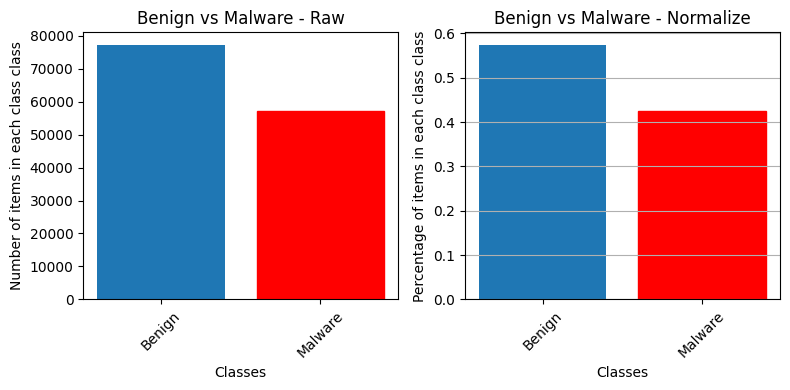

In [13]:
# This can be easily visualize
fig = plt.figure(figsize=(8,4), dpi=100)
plt.subplot(121)
plt.title('Benign vs Malware - Raw')
bar = plt.bar(x=unique_classes, height=counts)
bar[1].set_color('r')
plt.xticks(ticks=range(0, 2, 1), labels=['Benign','Malware'], rotation=45)
plt.xlabel('Classes')
plt.ylabel('Number of items in each class class')

plt.subplot(122)
plt.title('Benign vs Malware - Normalize')
bar = plt.bar(x=unique_classes, height=counts/sum(counts))
bar[1].set_color('r')
plt.xticks(ticks=range(0, 2, 1), labels=['Benign','Malware'], rotation=45)
plt.xlabel('Classes')
plt.ylabel('Percentage of items in each class class')
plt.grid(axis='y')

plt.tight_layout()
plt.show()

### Step 3:   
Split the data into train and test sets    
Pre-process the data   
prepare the data for the model

In [14]:
# Prepare the data for training
# First split into training and testing sets
from sklearn.model_selection import train_test_split

In [15]:
# Split the train and test sets
X_train, X_test, y_train, y_test = train_test_split(malware_features, malware_labels, train_size=.7, test_size=.3, random_state=10, stratify=malware_labels) 

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((94104, 2381), (94104,), (40331, 2381), (40331,))

In [16]:
# Preparing to Standardize and scale
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [17]:
# Before using PCA, we need to scale the data
std_scaler = StandardScaler(with_mean=True, with_std=True, copy=False)
X_train_scaled = std_scaler.fit_transform(X_train)

# Get the new stats
print(f'Max value: {X_train_scaled.max().item()}')
print(f'Min value: {X_train_scaled.min().item()}')
print(f'Mean value: {X_train_scaled.mean()}')
print(f'Std value: {X_train_scaled.std()}')

Max value: 306.7621154785156
Min value: -306.7621154785156
Mean value: -3.0893954061639306e-10
Std value: 0.9890177249908447


In [18]:
# Leverage PCA to reduce the number of features
pca = PCA(n_components=1024, random_state=10, copy=False)
X_train_scaled_scaled_pca = pca.fit_transform(X=X_train_scaled)
X_train_scaled_scaled_pca.shape

(94104, 1024)

You might be wondering why I choose 1024 above. Initially, I did so because I wanted two numbers that were squared 32*32, thus allowing for the use of Conv2d architecture. 
At the same time, this still retains almost 90% of the meaning of the data as can be seen below. This allows us to have a more efficient training process.

In [19]:
# Get the cumulative sum of the PCA vectors
np.cumsum(pca.explained_variance_ratio_)

array([0.05108532, 0.09247448, 0.11411697, ..., 0.89916795, 0.89933133,
       0.8994936 ], dtype=float32)

In [20]:
# Take out the last value 
# This is the amount of "meaning" of the data that we were able to retain  
np.cumsum(pca.explained_variance_ratio_)[-1]

np.float32(0.8994936)

### Step 3:   
Visualize a few samples from the dataset to identify malware vs benign   

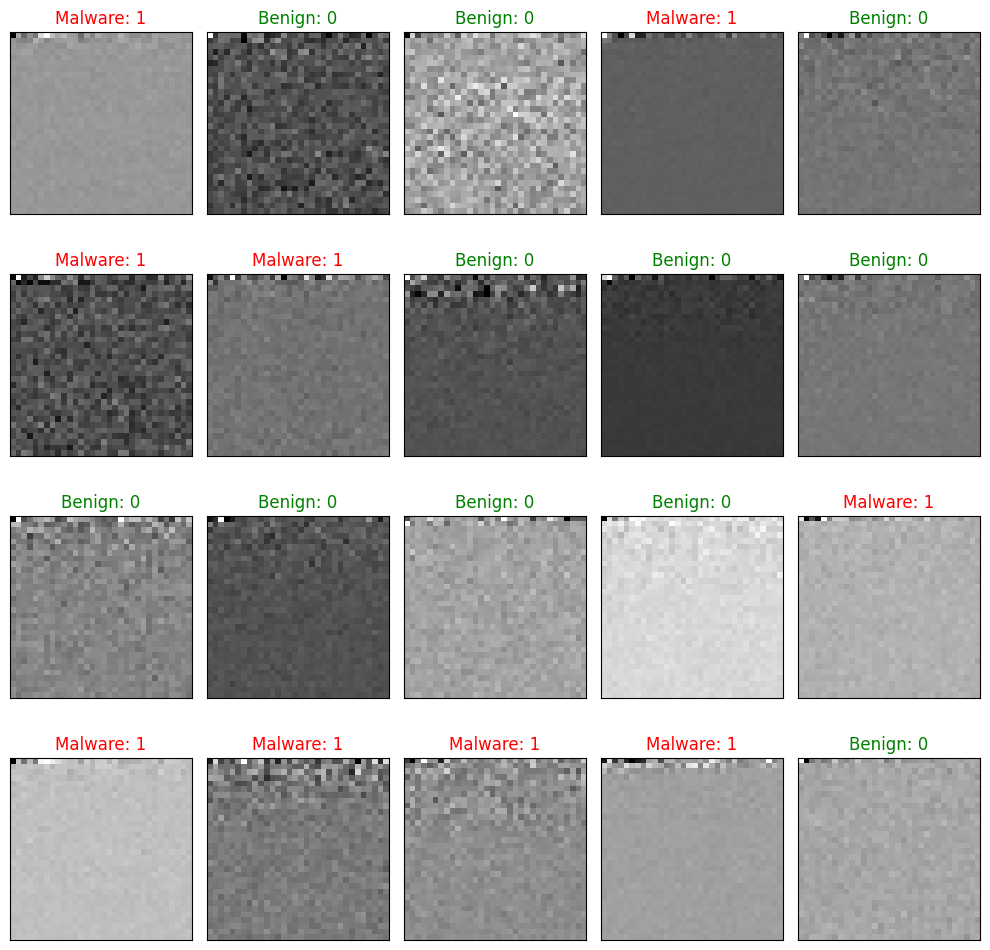

In [21]:
# You can adjust the size here
tmp_indices = np.random.randint(low=0, high=len(X_train_scaled_scaled_pca), size=(20))

plt.figure(figsize=(10, 10))
for idx, value in enumerate(tmp_indices):

    # Adjust the 4,5 here, if you changed the size above
    # Ensure it is a multiple of size
    ax = plt.subplot(4,5,idx+1)
    ax.set_title(label=f'Benign: {malware_labels[idx]}' if malware_labels[idx] == 0 else f'Malware: {malware_labels[idx]}', fontdict={'size' : 12, 'color' : 'green' if malware_labels[idx] == 0 else 'red'})
    ax.imshow(X_train_scaled_scaled_pca[value].reshape(32, 32), cmap='gray')
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()


### Step 4:   
Convert the data to torch tensor from numpy array   

In [22]:
# Have to convert this data to a torch tensor
# Put it on the device at the same time
X_train = torch.tensor(data=X_train_scaled_scaled_pca, dtype=torch.float32, device=device)

# Modify the labels also
# Put it on the device also
y_train = torch.tensor(data=y_train.reshape(-1, 1), dtype=torch.float32, device=device)
X_train.size(), y_train.shape

(torch.Size([94104, 1024]), torch.Size([94104, 1]))

In [23]:
# Get the unique count of the labels after splitting
torch.unique(y_train, return_counts=True)

(tensor([0., 1.], device='cuda:0'), tensor([54225, 39879], device='cuda:0'))

In [24]:
# Pre-process the test data also
# First scale it
X_test_scaled = std_scaler.transform(X=X_test)

# Perform PCA on this data now
# Notice the call only to transform and not fit_transform
X_test_scaled_pca = pca.transform(X=X_test_scaled)
X_test_scaled_pca.shape

(40331, 1024)

In [25]:
# Have to convert this test data to a torch tensor
X_test = torch.tensor(data=X_test_scaled_pca, dtype=torch.float32, device=device)

# Modify the test labels also
y_test = torch.tensor(data=y_test.reshape(-1, 1), dtype=torch.float32)

X_test.size(), X_test.size(), torch.unique(y_test, return_counts=True)


(torch.Size([40331, 1024]),
 torch.Size([40331, 1024]),
 (tensor([0., 1.]), tensor([23239, 17092])))

We should save a copy of the train and test sets just in case we need them for future 

In [26]:
# Save the train data
torch.save(obj=X_train, f=r'/tmp/bodmas_train_pca_scaled.pt')
np.savez_compressed(file=r'/tmp/bodmas_train_pca_scaled.npz', X=X_train.cpu().numpy(), y=y_train.cpu().numpy())


# Save the test data
torch.save(obj=X_test, f=r'/tmp/bodmas_test_pca_scaled.pt')
np.savez_compressed(file=r'/tmp/bodmas_test_pca_scaled.npz', X=X_test.cpu().numpy(), y= y_test.cpu().numpy())


# Verify the files were created
!ls /tmp/bodmas*pca*


/tmp/bodmas_test_pca_scaled.npz  /tmp/bodmas_train_pca_scaled.npz
/tmp/bodmas_test_pca_scaled.pt	 /tmp/bodmas_train_pca_scaled.pt


### Step 5:  
Take advantage of the dataloader to get the data into the model  

In [27]:
# With that out of the way, time to build a dataloader for the train data
from torch.utils.data import DataLoader
from tqdm import tqdm

In [28]:
# Define a batch size
batch_size = 32

# Setup the training dataloader
train_loader = DataLoader(dataset=list(zip(X_train, y_train)), batch_size=batch_size, shuffle=False)
train_loader

In [29]:
# Grab a sample batch
sample_batch_X, sample_batch_y = next(iter(train_loader))
sample_batch_X.shape, sample_batch_y.shape

(torch.Size([32, 1024]), torch.Size([32, 1]))

### Step 6:  
Build the model   

In [30]:
# Set a variable for the hidden dimensions
h_dim = 256

# Be dynamic about the shape of the input
in_features = sample_batch_X.size(dim=-1)

# Setup dropout for regularization
dropout_rate = 0.3

class MalwareClassifier(nn.Module):
    def __init__(self):
        super(MalwareClassifier, self).__init__()

        self.layers = nn.Sequential(
            # Create groups of Linear yayers
            nn.Linear(in_features=in_features, out_features=h_dim * 4, bias=True),
            nn.BatchNorm1d(num_features=h_dim * 4),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),

            nn.Linear(in_features=h_dim * 4, out_features=h_dim * 2, bias=True),
            nn.BatchNorm1d(num_features=h_dim * 2),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),

            nn.Linear(in_features=h_dim * 2, out_features=h_dim, bias=True),
            nn.BatchNorm1d(num_features=h_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(in_features=h_dim, out_features=1, bias=True),
            
        )

    
    def forward(self, x):
        x = self.layers(x)
        return x

In [31]:
# Setup a seed
seed=15
torch.manual_seed(seed=seed)

# Instantiate the model
# Put it on the device
malware_classifier = MalwareClassifier().to(device)

# Get the accuracy for the untrained model
# This gives insights into where we might be heading
untrained_accuracy = ( nn.Sigmoid()(malware_classifier(sample_batch_X)).round() == sample_batch_y ).sum() / sample_batch_y.shape[0]
untrained_accuracy

tensor(0.5000, device='cuda:0')

Looking at above you see 0.625 or basically 63%. This obviously would be excellent accuracy for a model that has not been trained. Let's put things into perspective. If you had to make a random guess, your guess would be 1/2. There are two classes and you could only choose 1 class, hence 1/2. This would result in 0.5 or 50% chance. Hence, our untrained model is not doing too bad at this point. Doing slightly better than human guess.

In [32]:
# Peek into the model architecture
torchinfo.summary(model=malware_classifier, input_size=sample_batch_X.size())

Layer (type:depth-idx)                   Output Shape              Param #
MalwareClassifier                        [32, 1]                   --
├─Sequential: 1-1                        [32, 1]                   --
│    └─Linear: 2-1                       [32, 1024]                1,049,600
│    └─BatchNorm1d: 2-2                  [32, 1024]                2,048
│    └─ReLU: 2-3                         [32, 1024]                --
│    └─Dropout: 2-4                      [32, 1024]                --
│    └─Linear: 2-5                       [32, 512]                 524,800
│    └─BatchNorm1d: 2-6                  [32, 512]                 1,024
│    └─ReLU: 2-7                         [32, 512]                 --
│    └─Dropout: 2-8                      [32, 512]                 --
│    └─Linear: 2-9                       [32, 256]                 131,328
│    └─BatchNorm1d: 2-10                 [32, 256]                 512
│    └─ReLU: 2-11                        [32, 256]           

In [33]:
# Capture the model architecture at the same time
import netron
from IPython.display import IFrame

In [34]:
# Visualize our model
torch.onnx.export(model=malware_classifier, args=sample_batch_X, f='/tmp/bodmas_malware_classifier.onnx', input_names=['features'], output_names=['softmax'], dynamo=False)
netron.start(file='/tmp/bodmas_malware_classifier.onnx', browse=False, address=('localhost', 8081) )
IFrame(src='http://localhost:8081', width=800, height=800)

Serving '/tmp/bodmas_malware_classifier.onnx' at http://localhost:8081


### Step 7:   
Instantiate the model again and prepare for training

In [35]:
# We could continue to use the untrained model above. However, let's switch things up a bit
torch.manual_seed(seed=seed)

# Put the model also on the device
# Just doing the same thing as above to keep it into one place
# Let's also call it model
model = MalwareClassifier().to(device=device)

# Setup the loss function
loss_fn = nn.BCEWithLogitsLoss(reduction='mean')

# Setup the optimizer
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-3, fused=True, weight_decay=1e-2)

# Setup a scheduler for learning rate decay
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=10, gamma=0.5)

let's train our network using MLflow. This is for multiple reasons but more importantly for the following:  
1. We will use this model later to target via Model Extraction attacks, etc.
2. It gives us the ability to see how to interact with an API

https://mlflow.org/docs/latest/deep-learning/pytorch/guide/  
https://mlflow.org/docs/latest/deep-learning/pytorch/quickstart/pytorch_quickstart  


Install MLflow
$ pip install --upgrade mlflow>=3.0.0rc0 --pre
https://mlflow.org/docs/latest/mlflow-3/


# With MLflow install start the service

$ mlflow server --host 0.0.0.0 --port 9999
[2025-05-08 13:07:42 -0400] [756265] [INFO] Starting gunicorn 23.0.0
[2025-05-08 13:07:42 -0400] [756265] [INFO] Listening at: http://0.0.0.0:9999 (756265)
[2025-05-08 13:07:42 -0400] [756265] [INFO] Using worker: sync


Here is an example of the mlflow home page   

<img style="max-width:50em; height:auto;" src="../graphics/example_mlflow_environment.png"/>


### Step 8:   
Train the model with mlflow  


In [36]:
# Setup a tracking url
mlflow_tracking_url = 'http://127.0.0.1:9999'

# Set the tracking URL
mlflow.set_tracking_uri(uri=mlflow_tracking_url)

# Setup the experiment
mlflow.set_experiment(experiment_name='malware_classifier')

Retrying (Retry(total=6, connect=7, read=6, redirect=7, status=7)) after connection broken by 'ConnectionResetError(104, 'Connection reset by peer')': /api/2.0/mlflow/experiments/get-by-name?experiment_name=malware_classifier
Retrying (Retry(total=5, connect=7, read=5, redirect=7, status=7)) after connection broken by 'ConnectionResetError(104, 'Connection reset by peer')': /api/2.0/mlflow/experiments/get-by-name?experiment_name=malware_classifier
Retrying (Retry(total=4, connect=7, read=4, redirect=7, status=7)) after connection broken by 'ConnectionResetError(104, 'Connection reset by peer')': /api/2.0/mlflow/experiments/get-by-name?experiment_name=malware_classifier
Retrying (Retry(total=3, connect=7, read=3, redirect=7, status=7)) after connection broken by 'ConnectionResetError(104, 'Connection reset by peer')': /api/2.0/mlflow/experiments/get-by-name?experiment_name=malware_classifier
Retrying (Retry(total=2, connect=7, read=2, redirect=7, status=7)) after connection broken by 'C

<Experiment: artifact_location='mlflow-artifacts:/296937887469882614', creation_time=1752417448307, experiment_id='296937887469882614', last_update_time=1752417448307, lifecycle_stage='active', name='malware_classifier', tags={}>

In [37]:
# Taka snapshot from the batch
test_batch = X_test[:10000]
y_test = y_test[:10000]
test_batch.shape, y_test.shape

(torch.Size([10000, 1024]), torch.Size([10000, 1]))

In [38]:
epochs = 3
loss_tracker = []
accuracy_tracker = []
test_accuracy_tracker = []
test_loss_tracker = []
print_stats_at = 1

# Wrap the training in a mlflow context
with mlflow.start_run() as mal_run:

    # Store the parameters for review in mlflow
    params = {
        'epochs' : epochs,
        'learning_rate' : optimizer.param_groups[0]['lr'],
        'batch_size' : batch_size,
        'loss_function' : loss_fn.__class__.__name__,
        'optimizer' : optimizer.__class__.__name__
    }

    # Actually log the parameters
    mlflow.log_params(params=params)

    for epoch in range(epochs):
        # Put the model in training mode
        model.train(mode=True)
        running_loss = 0.
        running_accuracy = 0. 

        # Track the number of batches in each iteration
        batch_n = 0

        for X, y in tqdm(iterable=train_loader, desc=f'Epoch: {epoch+1}/{epochs}'):

            # Move the data to the device
            X, y = X.to(device), y.to(device)
            
            # Clear the gradients for each batch, so they do not accumulate
            optimizer.zero_grad(set_to_none=True)

            # Get predictions
            logits = model(X)
            loss = loss_fn(logits, y)
            loss.backward()
            optimizer.step()

            # This is just to track the loss and accuracy across all batches
            running_loss += loss.item()
            running_accuracy += ((torch.round(nn.Sigmoid()(logits)) == y).sum() / y.size(dim=0)).item()

            batch_n += 1

        scheduler.step()
        loss_tracker.append(running_loss / batch_n )
        accuracy_tracker.append(running_accuracy / batch_n)

        # Track the test accuracy during training
        # Eval mode is needed because we are using dropout and batch normalization
        # These operate differently during training and inference
        model.eval()    
        test_logits = model(test_batch)
        test_accuracy = ((test_logits.sigmoid().round().cpu() == y_test.cpu()).sum() / y_test.cpu().shape[0]).item()
        test_accuracy_tracker.append(test_accuracy)
        test_loss = loss_fn(test_logits.cpu(), y_test.cpu()).item()
        test_loss_tracker.append(test_loss)

        # print the model statistics after
        if (epoch + 1) % print_stats_at == 0:
            print(f'Loss: {running_loss/len(train_loader)} \t Accuracy: {running_accuracy / batch_n}  \t Test Loss: {test_loss}   Test Accuracy: {test_accuracy} ')
            mlflow.log_metric(key='training_loss', value=running_loss / batch_n, step=(epoch + 1) // print_stats_at )
            mlflow.log_metric(key='training_accuracy', value=running_accuracy / batch_n, step=(epoch + 1) // print_stats_at )
            mlflow.log_metric(key='testing_loss', value=test_loss, step=(epoch + 1) // print_stats_at )
            mlflow.log_metric(key='test_accuracy', value=test_accuracy, step=(epoch + 1) // print_stats_at )
        #break

    # Setup the model signature.
    # This is just telling mlflow what the input and output looks like
    # These have to be numpy arrays
    model_signature = mlflow.models.infer_signature(model_input=X_train.cpu().numpy(), model_output=model(X_train).detach().cpu().numpy())

    # Log the model after training
    model_info = mlflow.pytorch.log_model(pytorch_model=torch.jit.export(model), name='malware_classifier', signature=model_signature, ) # To register the model add: registered_model_name='malware_classifier"""

Epoch: 1/3: 100%|██████████| 2941/2941 [00:14<00:00, 207.45it/s]


Loss: 0.060704058853431046 	 Accuracy: 0.9790852034590513  	 Test Loss: 0.027164209634065628   Test Accuracy: 0.9912999868392944 


Epoch: 2/3: 100%|██████████| 2941/2941 [00:14<00:00, 209.01it/s]


Loss: 0.028306362723236937 	 Accuracy: 0.9902208715991396  	 Test Loss: 0.02045615203678608   Test Accuracy: 0.9932000041007996 


Epoch: 3/3: 100%|██████████| 2941/2941 [00:14<00:00, 196.68it/s]


Loss: 0.01795068740381272 	 Accuracy: 0.9940106823143607  	 Test Loss: 0.02143772691488266   Test Accuracy: 0.9936000108718872 


2025/08/01 21:04:04 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.1+cu128) contains a local version label (+cu128). MLflow logged a pip requirement for this package as 'torch==2.7.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/08/01 21:04:13 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.1+cu128) contains a local version label (+cu128). MLflow logged a pip requirement for this package as 'torch==2.7.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


🏃 View run languid-lark-456 at: http://127.0.0.1:9999/#/experiments/296937887469882614/runs/3018958d1877425886f539304355c56c
🧪 View experiment at: http://127.0.0.1:9999/#/experiments/296937887469882614


In [39]:
# With the training finish clear the GPU cache
# Setup the device to work with
if torch.cuda.is_available():
    # For CUDA GPU
    print(f'Cleaning {device} cache')
    torch.cuda.empty_cache()
elif torch.backends.mps.is_available():
    # For Apple devices
    print(f'Cleaning {device} cache')
    torch.mps.empty_cache()
else:
    # Default to cpu
    pass

Cleaning cuda cache


### Step 9:  
Visualize the training performance  

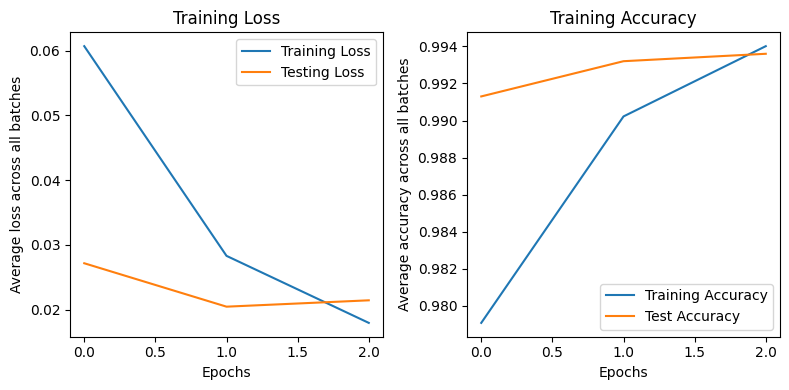

In [40]:
# Visualize the loss and accuracy of the training data
plt.figure(figsize=(8, 4))

plt.subplot(121)
plt.title('Training Loss')
plt.plot(range(0, len(loss_tracker)), loss_tracker, label='Training Loss')
plt.plot(range(0, len(loss_tracker)), test_loss_tracker, label='Testing Loss')
plt.xlabel(xlabel='Epochs')
plt.ylabel('Average loss across all batches')
plt.legend()

plt.subplot(122)
plt.title('Training Accuracy')
plt.plot(range(0, len(accuracy_tracker)), accuracy_tracker, label='Training Accuracy')
plt.plot(range(0, len(accuracy_tracker)), test_accuracy_tracker, label='Test Accuracy')

plt.xlabel(xlabel='Epochs')
plt.ylabel('Average accuracy across all batches')
plt.legend()

plt.tight_layout()

Above suggest you can train this model for longer and get even better accuracy. This conclusion was drawn because we can see the training loss continues to go down while the accuracy continues to go up. 

I however, would not continue training. Looking at the test loss, it continues to diverge from the train loss. Similar the accuracy is beginning to diverge. It even seems like the testing accuracy is descending.   

If you are using a device with a GPU, go ahead and change the epochs 100 and retry you should get much better training accuracy than is in this notebook. I stopped the training because I would like this to be accessible to everyone.   
Besides over 99% training accuracy after 10 epochs is very good for the problem we are trying to solve.   

### Step 10:   
Interact with the model  

In [41]:
# Capture some information about the run
#logged_model = f'runs:/{mal_run.info.run_id}/malware_classifier'
print(f'Model URI: {model_info.model_uri}')

Model URI: models:/m-a1e7ff141be3470f98400809786aaa8f


- Remember to store the MLFlow tracking server as an environment variable   
-  export MLFLOW_TRACKING_URI=http://0.0.0.0:9999

- Verify the environment variable is created    
- $ env | grep MLFLOW     
MLFLOW_TRACKING_URI=http://0.0.0.0:9999    

- If you wish to run load this model at the mlflow command line, you could run   
model_info.model_uri   

This gives the URI that looks something like: 
models:/m-15b26825534549ce8185065073f6937e    

With this information, you can now run the model in the comnand line   
$ mlflow models serve --model-uri models:/m-15b26825534549ce8185065073f6937e --port 5000 --no-conda


### The results in the shell should look like    
$ mlflow models serve --model-uri models:/m-15b26825534549ce8185065073f6937e --port 5000 --no-conda    
Downloading artifacts: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 12.41it/s]     
2025/06/12 14:06:10 INFO mlflow.models.flavor_backend_registry: Selected backend for flavor 'python_function'     
Downloading artifacts: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 15.80it/s]      
2025/06/12 14:06:10 INFO mlflow.pyfunc.backend: === Running command 'exec uvicorn --host 127.0.0.1 --port 5000 --workers 1 mlflow.pyfunc.scoring_server.app:app'     
INFO:     Started server process [19958]     
INFO:     Waiting for application startup.     
INFO:     Application startup complete.     
INFO:     Uvicorn running on http://127.0.0.1:5000 (Press CTRL+C to quit)     


In [42]:
# Capture some information about the run
#logged_model = f'runs:/{mal_run.info.run_id}/malware_classifier'
# print(f'Model URI: {model_info.model_uri}')

# Load the model
loaded_mal_classifier = mlflow.pyfunc.load_model(model_info.model_uri)
loaded_mal_classifier

mlflow.pyfunc.loaded_model:
  artifact_path: mlflow-artifacts:/296937887469882614/models/m-a1e7ff141be3470f98400809786aaa8f/artifacts
  flavor: mlflow.pytorch
  run_id: 3018958d1877425886f539304355c56c

### Step 11:   
Load the model and make predictions on unforeseen data. 

Do keep in mind, we already have some insights into how it is doing as we tested the model during training.   

In [43]:
# For this purpose we could use the loaded model to make predictions
raw_logits = loaded_mal_classifier.predict(data=test_batch.cpu().numpy())

# View the first 10
raw_logits[:10]

array([[-22.245363 ],
       [  8.402219 ],
       [ 15.592919 ],
       [-20.18794  ],
       [ -7.4921703],
       [ -4.8538413],
       [-15.812358 ],
       [ -8.031071 ],
       [  2.920619 ],
       [-11.402638 ]], dtype=float32)

Above represent the raw outputs from the network. The **logits**. We need to make predictions, hence we need to get the probabilities. To get the probabilities, we leverage the sigmoid activation function on the data above. 

We could use Torch Sigmoid function to get the probabilities. However, this requires we convert the data to torch tensors first. Let us just create our own sigmoid Activation function.

In [44]:
# Import a scipy library
from scipy.special import expit

In [45]:
# Get the probs 
probs = expit(raw_logits)

# Look at the first 10 probs
probs[:10]

array([[2.1825364e-10],
       [9.9977571e-01],
       [9.9999988e-01],
       [1.7080036e-09],
       [5.5712130e-04],
       [7.7380198e-03],
       [1.3576260e-07],
       [3.2509409e-04],
       [9.4885629e-01],
       [1.1165861e-05]], dtype=float32)

In [46]:
# Get the actual class
predicted_class = probs.round()
predicted_class[:10]

array([[0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.]], dtype=float32)

In [47]:
# With the labels in place, let's get the accuracy
( predicted_class == y_test ).sum() / y_test.shape[0]

tensor(0.9936)

### Step 12:   
Visualize the model's performance on the test data   

In [48]:
# Visualize the model's performance
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix

In [49]:
# Setup the confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=predicted_class)
cm

array([[5731,   26],
       [  38, 4205]])

<Figure size 500x500 with 0 Axes>

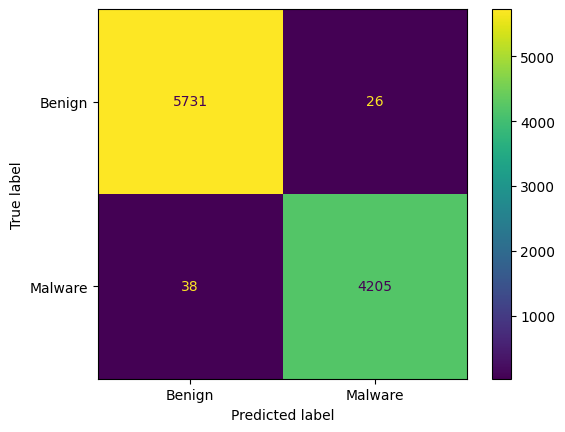

In [50]:
# Get better visuals
ax = plt.figure(figsize=(5,5))
ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=predicted_class, display_labels=class_labels);

In [51]:
# Finally the classification report
print(classification_report(y_true=y_test, y_pred=predicted_class))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      5757
         1.0       0.99      0.99      0.99      4243

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [52]:
# Assuming we are satisfied with this model's performance, save it for later inference
torch.jit.script(model).save(r'/tmp/bodmas_malware_classifier.jit')

# Verify the file has been created
!ls /tmp/bodmas_malware_classifier.jit

/tmp/bodmas_malware_classifier.jit


### Step 13:  
Validate that the model can be accessed remotely via an API endpoint    

Ensure the mlflow server is still running from above 

In [53]:
# Import the needed library
import json
import requests
from scipy.special import expit
from datetime import datetime as dt

In [55]:
# Confirm the server is available for prediction
requests.get(url='http://127.0.0.1:5000/ping')

<Response [200]>

In [56]:
# Verify the version of the server hosting the API
requests.get(url='http://127.0.0.1:5000/version').content

b'3.1.1'

In [57]:
# Setup the API endpoint
inference_url = 'http://localhost:5000/invocations'
inference_url

'http://localhost:5000/invocations'

In [58]:
# Setup the HTTP Headers
headers = {'Content-Type' : 'application/json', 'User-agent': 'SecurityNik', 'X-Forwarded-For': '10.0.0.1'}
headers

{'Content-Type': 'application/json',
 'User-agent': 'SecurityNik',
 'X-Forwarded-For': '10.0.0.1'}

In [59]:
# Get some sample data from the existing training set
payload = json.dumps(
    {
        'inputs' : X_test[59:60].tolist()     
    }
)

payload

'{"inputs": [[-13.203332901000977, 1.529018521308899, -4.610655784606934, -0.4184646010398865, -3.337534189224243, 5.882669448852539, 9.462151527404785, 3.3543848991394043, 1.872493028640747, 3.2442164421081543, 0.5607929229736328, 0.571627676486969, -4.243643283843994, 1.2048224210739136, -1.5889896154403687, 1.6848889589309692, 0.21475932002067566, -0.7947322130203247, 0.23324036598205566, 3.5180113315582275, -0.04548047482967377, -0.8996065855026245, -1.19831120967865, 0.29699426889419556, -0.5038065910339355, 0.8936067819595337, -0.7431834936141968, 0.8323036432266235, 0.537203311920166, 0.6018947958946228, -0.09089645743370056, -1.5495123863220215, -1.0921205282211304, -1.4490599632263184, -0.9638904929161072, -0.7836689352989197, 2.103243827819824, 0.5329784750938416, -0.5568817853927612, -0.34025028347969055, 0.26746463775634766, 0.4781699776649475, 1.213504433631897, 0.8851220607757568, -1.8374563455581665, -0.679618775844574, -0.6491177678108215, -0.24041704833507538, 0.183804

Once you run the cell above, come back and try a few other single samples by replacing the *test_raw_bits[:1].tolist()* with one of the following:   
X_test[-1:].tolist()   
X_test[3:4].tolist()   
X_test[10:11].tolist()   
X_test[59:60].tolist()  
X_test[:1].tolist()  



In [60]:
# Get the predictions
# Remember this is the raw logits
response = requests.post(url=inference_url, data=payload, headers=headers).json()
logits = response['predictions']
logits 

[[-16.455944061279297]]

In [61]:
# Get the probabilities
prob = expit(logits)[0].item()
prob

7.133033582577086e-08

In [62]:
# Setup the class
predicted_class = class_labels[0] if prob < .5 else class_labels[1]
predicted_class

'Benign'

In [63]:
# Alternatively, we could get the class by indexing into our labels
class_labels[int(probs.round()[0].item())]

'Benign'

If we wanted, we could also do a batch prediction, and get those confidence scores. This approach will be very helpful when it is time to perform model extraction attacks against this model.   


In [64]:
# Using a batch from our test data
payload = json.dumps(
    {
        'inputs' : X_test[40:60].tolist()     
    }
)

payload

'{"inputs": [[7.511620998382568, 12.020679473876953, 1.5335935354232788, 0.45163825154304504, -0.00896321702748537, -4.42623233795166, 2.3013031482696533, -1.5671679973602295, 1.9703881740570068, -1.7878756523132324, 6.3251118659973145, -0.36500123143196106, -0.42627063393592834, -0.9774364829063416, -0.29049476981163025, 0.4619607925415039, 0.6289350986480713, 0.7904638051986694, 2.5756402015686035, 5.3480424880981445, -2.0338985919952393, -4.558513164520264, -4.417503833770752, -1.157471776008606, 3.5635509490966797, -1.3433341979980469, 0.9458954930305481, 0.0007285751053132117, 1.2112194299697876, -1.4498385190963745, 0.39255547523498535, -0.10875619947910309, 0.7585079073905945, 0.7373393177986145, -0.502997875213623, 0.026270052418112755, -1.163246512413025, -0.8917748332023621, 0.26661962270736694, 0.7384671568870544, -1.7691601514816284, -1.100251317024231, 1.2390692234039307, 0.976760983467102, 0.8850905299186707, 0.24051375687122345, -0.21533608436584473, -0.6221760511398315,

In [65]:
# Get the predictions on the batch
response = requests.post(url=inference_url, data=payload, headers=headers).json()
logits = response['predictions']
logits

[[12.562273979187012],
 [-18.069799423217773],
 [15.418169021606445],
 [-10.72209358215332],
 [11.699507713317871],
 [-9.482898712158203],
 [-7.997216701507568],
 [-18.85724639892578],
 [12.750321388244629],
 [-10.417257308959961],
 [11.033892631530762],
 [-10.883773803710938],
 [-8.290897369384766],
 [5.31810998916626],
 [-10.59927749633789],
 [-12.487671852111816],
 [-12.010093688964844],
 [8.935934066772461],
 [10.078892707824707],
 [-16.455944061279297]]

In [ ]:
# Get the class for each sample in the batch
label = expit(logits).round()
label

array([[1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.]])

: 

### Lab Takeaways:   
- We were able to build a binary malware classifier using the BODMAS dataset. 
- We should now look to evade this classifier that is doing pretty well.  
- We saw that we are getting 99% accuracy on this data.